<a href="https://colab.research.google.com/github/gantir/eva4/blob/develop/s10/s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [2]:
# Manually unpgrading albumentations so the issue with ContextVersion not found when installing evalib is removed.
!pip uninstall albumentations -y
!pip uninstall imgaug -y
!pip install albumentations --upgrade

Uninstalling albumentations-0.4.5:
  Successfully uninstalled albumentations-0.4.5
Uninstalling imgaug-0.2.6:
  Successfully uninstalled imgaug-0.2.6
Processing /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3/albumentations-0.4.5-cp36-none-any.whl
Processing /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0/imgaug-0.2.6-cp36-none-any.whl


In [3]:
!pip install git+https://github.com/gantir/evalib.git@develop

  Cloning https://github.com/gantir/evalib.git (to revision develop) to /tmp/pip-req-build-me74x3l7
  Running command git clone -q https://github.com/gantir/evalib.git /tmp/pip-req-build-me74x3l7
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Created wheel for evalib: filename=evalib-0.0.post0.dev35+geab834f-py2.py3-none-any.whl size=19774 sha256=51e9dcc17f9fa19c2ae97d8671658e0595fa2a2ebed6229cb0a047d8096e6926
  Stored in directory: /tmp/pip-ephem-wheel-cache-tlfm0dsv/wheels/f6/38/b2/08942c9ce5bbe47f487156274e09033e4abe51a7acad6a6d66
Successfully built evalib


In [4]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive/')
except:
  print('May be not using Google Colab')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
from __future__ import print_function
import sys
from argparse import Namespace

import torch
import torchvision
from torchvision import  transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from matplotlib.pyplot import imshow

In [6]:
import evalib
from evalib.gradcam.gradcam import GradCAM, GradCAMpp
from evalib.gradcam.utils import visualize_cam
from evalib.lr import lr_finder


  pip install torch-lr-finder -v --global-option="amp"


In [0]:
config = Namespace(
    batch_size = 64,
    batch_size_cuda = 64,
    num_workers = 4,
    SEED = 170,
    EPOCHS = 50,
    dropout = 0.0,
    lr = 1e-3,
    momentum = 0.9,
    l1_decay =  0,
    l2_decay = 1e-4   
)
evalib.utils.init_seed(config.SEED)

In [8]:
data = evalib.data.cifar.CIFAR(config)

Extracting ./data/cifar-10-python.tar.gz to ./data


 deer   dog truck  bird


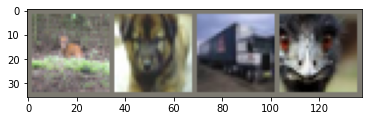

In [9]:
data_iter = iter(data.test_loader)
images, labels = data_iter.next()
index_start, index_end = 32,36
evalib.plot.imshow_torch(torchvision.utils.make_grid(images[index_start:index_end]))
print(' '.join('%5s' % data.classes[label] for label in labels[index_start:index_end]))

# imshow(transforms.ToPILImage()(images[32]))

In [10]:
net = evalib.models.resnet.ResNet18(config.dropout)
model = net.to(evalib.utils.get_device())
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
def configure_optimizers(params, conf):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params, lr=conf.lr, momentum=conf.momentum, weight_decay=conf.l2_decay)
  # scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
  scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True, min_lr=1e-5)
  return criterion, optimizer, scheduler

In [0]:
criterion, optimizer, scheduler = configure_optimizers(model.parameters(), config)

lr_f = lr_finder.LRFinder(model, optimizer, criterion, device=evalib.utils.get_device())
lr_f.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-5, end_lr=2, num_iter=len(data.train_loader), step_mode="exp")
lr_f.plot()
lr_f.reset()



Learning rate search finished. See the graph with {finder_name}.plot()


In [0]:
best_lr = lr_f.history['lr'][lr_f.history['loss'].index(lr_f.best_loss)]
print("Best LR: {}".format(best_lr))
config.lr = best_lr


Best LR: 0.0021811709453896655


In [0]:
config.lr = 0.0021811709453896655
criterion, optimizer, scheduler = configure_optimizers(model.parameters(), config)

In [13]:
[(train_acc, train_loss), (val_acc, val_loss)] = evalib.tnt.train_n_test(model, criterion, optimizer, scheduler, data.train_loader, data.test_loader, num_epochs=config.EPOCHS)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1


Batch Id/Size: 782/50000, Training Loss: 1.78535807, Training Accuracy: 48.6220%: 100%|██████████| 782/782 [00:34<00:00, 22.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01659758, Test Accuracy: 62.5300%

Epoch: 2


Batch Id/Size: 782/50000, Training Loss: 1.08587050, Training Accuracy: 65.0380%: 100%|██████████| 782/782 [00:35<00:00, 22.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01266409, Test Accuracy: 71.7800%

Epoch: 3


Batch Id/Size: 782/50000, Training Loss: 1.17661810, Training Accuracy: 72.0680%: 100%|██████████| 782/782 [00:35<00:00, 22.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01088592, Test Accuracy: 76.2800%

Epoch: 4


Batch Id/Size: 782/50000, Training Loss: 1.00632238, Training Accuracy: 75.7720%: 100%|██████████| 782/782 [00:35<00:00, 22.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01032507, Test Accuracy: 78.1600%

Epoch: 5


Batch Id/Size: 782/50000, Training Loss: 0.57444251, Training Accuracy: 78.6480%: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01076251, Test Accuracy: 77.6100%

Epoch: 6


Batch Id/Size: 782/50000, Training Loss: 0.68803525, Training Accuracy: 80.5680%: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00853004, Test Accuracy: 82.0400%

Epoch: 7


Batch Id/Size: 782/50000, Training Loss: 0.57929134, Training Accuracy: 82.5780%: 100%|██████████| 782/782 [00:35<00:00, 22.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00803394, Test Accuracy: 82.8600%

Epoch: 8


Batch Id/Size: 782/50000, Training Loss: 0.43866497, Training Accuracy: 83.8220%: 100%|██████████| 782/782 [00:35<00:00, 22.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00829801, Test Accuracy: 82.7300%

Epoch: 9


Batch Id/Size: 782/50000, Training Loss: 0.39275432, Training Accuracy: 84.9820%: 100%|██████████| 782/782 [00:35<00:00, 22.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00725603, Test Accuracy: 84.7600%

Epoch: 10


Batch Id/Size: 782/50000, Training Loss: 0.59826690, Training Accuracy: 86.1140%: 100%|██████████| 782/782 [00:35<00:00, 22.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00731221, Test Accuracy: 85.1100%

Epoch: 11


Batch Id/Size: 782/50000, Training Loss: 0.71395200, Training Accuracy: 87.1160%: 100%|██████████| 782/782 [00:35<00:00, 22.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00765307, Test Accuracy: 84.7900%

Epoch: 12


Batch Id/Size: 782/50000, Training Loss: 0.11863776, Training Accuracy: 88.0900%: 100%|██████████| 782/782 [00:35<00:00, 22.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00769990, Test Accuracy: 84.5600%

Epoch: 13


Batch Id/Size: 782/50000, Training Loss: 0.39658388, Training Accuracy: 88.8820%: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00706553, Test Accuracy: 85.4100%

Epoch: 14


Batch Id/Size: 782/50000, Training Loss: 0.11371166, Training Accuracy: 89.3540%: 100%|██████████| 782/782 [00:35<00:00, 22.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00652186, Test Accuracy: 86.5600%

Epoch: 15


Batch Id/Size: 782/50000, Training Loss: 0.04395795, Training Accuracy: 90.0660%: 100%|██████████| 782/782 [00:35<00:00, 22.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00691494, Test Accuracy: 86.5000%

Epoch: 16


Batch Id/Size: 782/50000, Training Loss: 0.21780069, Training Accuracy: 90.5980%: 100%|██████████| 782/782 [00:35<00:00, 22.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00668245, Test Accuracy: 86.5300%

Epoch: 17


Batch Id/Size: 782/50000, Training Loss: 0.12985781, Training Accuracy: 91.1560%: 100%|██████████| 782/782 [00:35<00:00, 22.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00642337, Test Accuracy: 86.8600%

Epoch: 18


Batch Id/Size: 782/50000, Training Loss: 0.28038695, Training Accuracy: 91.4460%: 100%|██████████| 782/782 [00:34<00:00, 22.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00686745, Test Accuracy: 86.5400%

Epoch: 19


Batch Id/Size: 782/50000, Training Loss: 0.02983591, Training Accuracy: 92.1000%: 100%|██████████| 782/782 [00:35<00:00, 22.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00677257, Test Accuracy: 87.2100%

Epoch: 20


Batch Id/Size: 782/50000, Training Loss: 0.05132720, Training Accuracy: 92.4860%: 100%|██████████| 782/782 [00:35<00:00, 22.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00610303, Test Accuracy: 88.1500%

Epoch: 21


Batch Id/Size: 782/50000, Training Loss: 0.13628685, Training Accuracy: 92.7900%: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00708194, Test Accuracy: 86.6800%

Epoch: 22


Batch Id/Size: 782/50000, Training Loss: 0.08313021, Training Accuracy: 93.2600%: 100%|██████████| 782/782 [00:35<00:00, 22.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00757857, Test Accuracy: 86.2900%

Epoch: 23


Batch Id/Size: 782/50000, Training Loss: 0.01910985, Training Accuracy: 93.5080%: 100%|██████████| 782/782 [00:34<00:00, 22.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00680852, Test Accuracy: 87.7700%

Epoch: 24


Batch Id/Size: 782/50000, Training Loss: 0.07121521, Training Accuracy: 93.6500%: 100%|██████████| 782/782 [00:35<00:00, 22.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00646406, Test Accuracy: 87.7800%

Epoch    24: reducing learning rate of group 0 to 2.1812e-04.
Epoch: 25


Batch Id/Size: 782/50000, Training Loss: 0.09103045, Training Accuracy: 95.6280%: 100%|██████████| 782/782 [00:35<00:00, 22.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00530449, Test Accuracy: 89.6100%

Epoch: 26


Batch Id/Size: 782/50000, Training Loss: 0.01995733, Training Accuracy: 96.5260%: 100%|██████████| 782/782 [00:35<00:00, 22.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00515454, Test Accuracy: 89.9800%

Epoch: 27


Batch Id/Size: 782/50000, Training Loss: 0.08637518, Training Accuracy: 96.5240%: 100%|██████████| 782/782 [00:35<00:00, 22.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00514727, Test Accuracy: 90.0900%

Epoch: 28


Batch Id/Size: 782/50000, Training Loss: 0.04396510, Training Accuracy: 96.8720%: 100%|██████████| 782/782 [00:35<00:00, 22.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00519859, Test Accuracy: 90.1700%

Epoch: 29


Batch Id/Size: 782/50000, Training Loss: 0.04214656, Training Accuracy: 97.0220%: 100%|██████████| 782/782 [00:35<00:00, 22.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00518413, Test Accuracy: 90.2000%

Epoch: 30


Batch Id/Size: 782/50000, Training Loss: 0.02077898, Training Accuracy: 97.0060%: 100%|██████████| 782/782 [00:35<00:00, 22.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00517990, Test Accuracy: 90.2000%

Epoch: 31


Batch Id/Size: 782/50000, Training Loss: 0.01866740, Training Accuracy: 97.3120%: 100%|██████████| 782/782 [00:35<00:00, 22.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00521007, Test Accuracy: 90.2100%

Epoch    31: reducing learning rate of group 0 to 2.1812e-05.
Epoch: 32


Batch Id/Size: 782/50000, Training Loss: 0.02071127, Training Accuracy: 97.1800%: 100%|██████████| 782/782 [00:35<00:00, 22.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00517523, Test Accuracy: 90.2300%

Epoch: 33


Batch Id/Size: 782/50000, Training Loss: 0.00757086, Training Accuracy: 97.3340%: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00518184, Test Accuracy: 90.1800%

Epoch: 34


Batch Id/Size: 782/50000, Training Loss: 0.02244970, Training Accuracy: 97.5040%: 100%|██████████| 782/782 [00:35<00:00, 22.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00519322, Test Accuracy: 90.2600%

Epoch: 35


Batch Id/Size: 782/50000, Training Loss: 0.00425524, Training Accuracy: 97.4380%: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00517125, Test Accuracy: 90.2600%

Epoch    35: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 36


Batch Id/Size: 782/50000, Training Loss: 0.03906009, Training Accuracy: 97.3760%: 100%|██████████| 782/782 [00:35<00:00, 22.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00514265, Test Accuracy: 90.3400%

Epoch: 37


Batch Id/Size: 782/50000, Training Loss: 0.02610487, Training Accuracy: 97.4660%: 100%|██████████| 782/782 [00:35<00:00, 22.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00514974, Test Accuracy: 90.3400%

Epoch: 38


Batch Id/Size: 782/50000, Training Loss: 0.00667152, Training Accuracy: 97.5000%: 100%|██████████| 782/782 [00:35<00:00, 22.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00515655, Test Accuracy: 90.3200%

Epoch: 39


Batch Id/Size: 782/50000, Training Loss: 0.00372252, Training Accuracy: 97.4120%: 100%|██████████| 782/782 [00:35<00:00, 22.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00515067, Test Accuracy: 90.4900%

Epoch: 40


Batch Id/Size: 782/50000, Training Loss: 0.00199601, Training Accuracy: 97.4020%: 100%|██████████| 782/782 [00:35<00:00, 22.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00514192, Test Accuracy: 90.3900%

Epoch: 41


Batch Id/Size: 782/50000, Training Loss: 0.00105423, Training Accuracy: 97.3380%: 100%|██████████| 782/782 [00:35<00:00, 22.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00514549, Test Accuracy: 90.4000%

Epoch: 42


Batch Id/Size: 782/50000, Training Loss: 0.00364807, Training Accuracy: 97.6000%: 100%|██████████| 782/782 [00:35<00:00, 22.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00514432, Test Accuracy: 90.4200%

Epoch: 43


Batch Id/Size: 782/50000, Training Loss: 0.00470555, Training Accuracy: 97.5520%: 100%|██████████| 782/782 [00:35<00:00, 22.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00514317, Test Accuracy: 90.4400%

Epoch: 44


Batch Id/Size: 782/50000, Training Loss: 0.01156765, Training Accuracy: 97.4380%: 100%|██████████| 782/782 [00:35<00:00, 22.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00516339, Test Accuracy: 90.3900%

Epoch: 45


Batch Id/Size: 782/50000, Training Loss: 0.01448658, Training Accuracy: 97.4900%: 100%|██████████| 782/782 [00:35<00:00, 21.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00514537, Test Accuracy: 90.3700%

Epoch: 46


Batch Id/Size: 782/50000, Training Loss: 0.06643060, Training Accuracy: 97.5740%: 100%|██████████| 782/782 [00:35<00:00, 22.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00513835, Test Accuracy: 90.3900%

Epoch: 47


Batch Id/Size: 782/50000, Training Loss: 0.02147934, Training Accuracy: 97.4840%: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00514477, Test Accuracy: 90.3500%

Epoch: 48


Batch Id/Size: 782/50000, Training Loss: 0.02361622, Training Accuracy: 97.4880%: 100%|██████████| 782/782 [00:35<00:00, 22.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00513732, Test Accuracy: 90.4100%

Epoch: 49


Batch Id/Size: 782/50000, Training Loss: 0.04188666, Training Accuracy: 97.6080%: 100%|██████████| 782/782 [00:35<00:00, 22.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00512160, Test Accuracy: 90.3800%

Epoch: 50


Batch Id/Size: 782/50000, Training Loss: 0.00600773, Training Accuracy: 97.4680%: 100%|██████████| 782/782 [00:35<00:00, 22.09it/s]
100%|██████████| 157/157 [00:03<00:00, 45.02it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00512790, Test Accuracy: 90.5100%



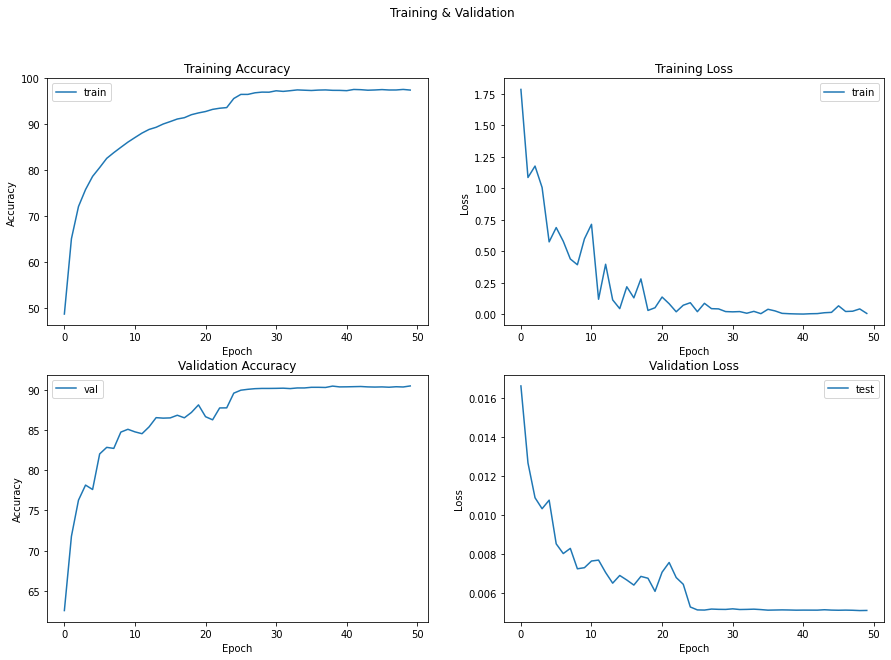

In [14]:
evalib.plot.plot_acc_loss(
    {'train': train_acc},
    {'val': val_acc},
    {'train': train_loss},
    {'test': val_loss}
)

In [0]:
c,w = evalib.tnt.get_correct_wrong_predictions(model, data.test_loader,count=25)

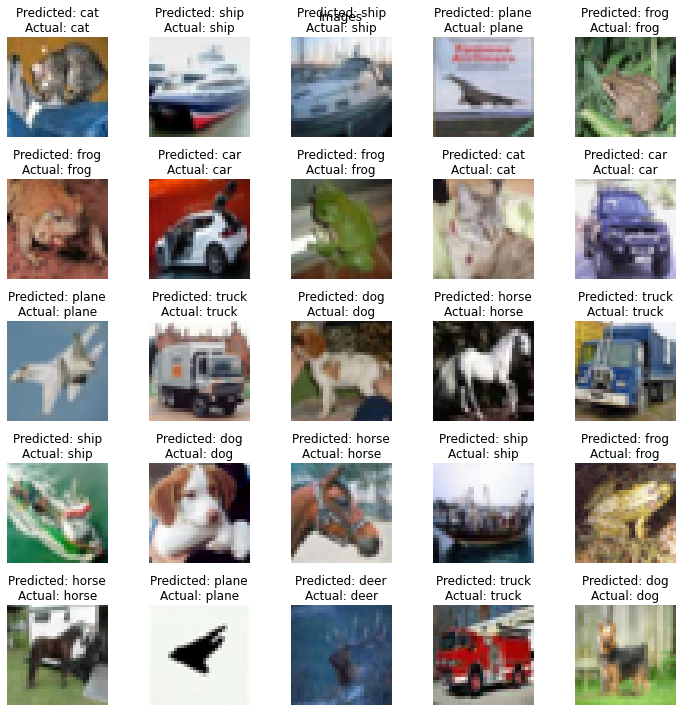

In [16]:
evalib.plot.plot_images(c, data.classes, "correct_imgs.png")


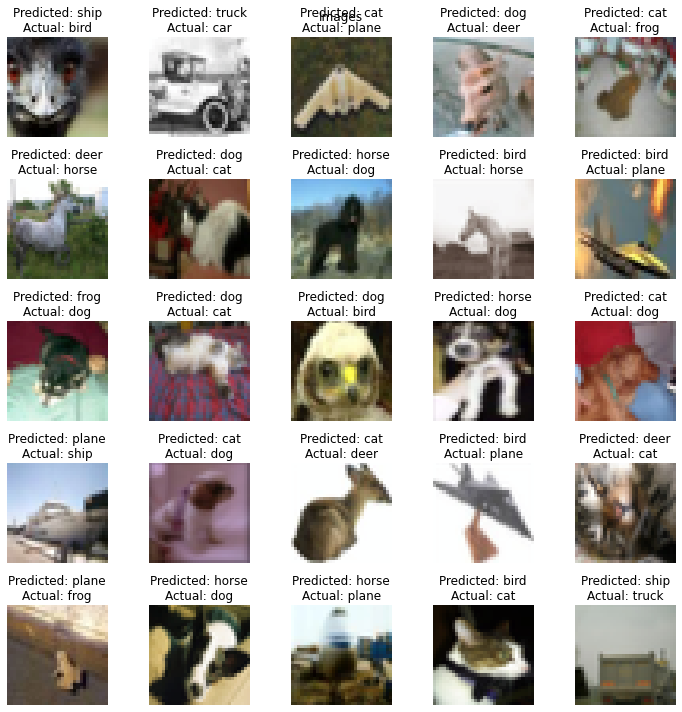

In [17]:
evalib.plot.plot_images(w, data.classes, "wrong_imgs.png")

In [0]:
# Grad Cam
configs = [
    dict(model_type='resnet', arch=model, layer_name='layer1'),
    dict(model_type='resnet', arch=model, layer_name='layer2'),
    dict(model_type='resnet', arch=model, layer_name='layer3'),
    dict(model_type='resnet', arch=model, layer_name='layer4'),
]

for config in configs:
    config['arch'].to(evalib.utils.get_device()).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [0]:
torch_images = [i['img'].to(evalib.utils.get_device()) for i in w]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


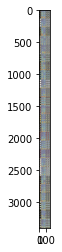

In [20]:
images = []
for torch_img in torch_images:
  normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
  for gradcam, gradcam_pp in cams:
      mask, _ = gradcam(normed_torch_img)
      heatmap, result = visualize_cam(mask, torch_img)

      mask_pp, _ = gradcam_pp(normed_torch_img)
      heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
      
      images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

grid_image = torchvision.utils.make_grid(images, nrow=5)
evalib.plot.imshow_torch(grid_image)

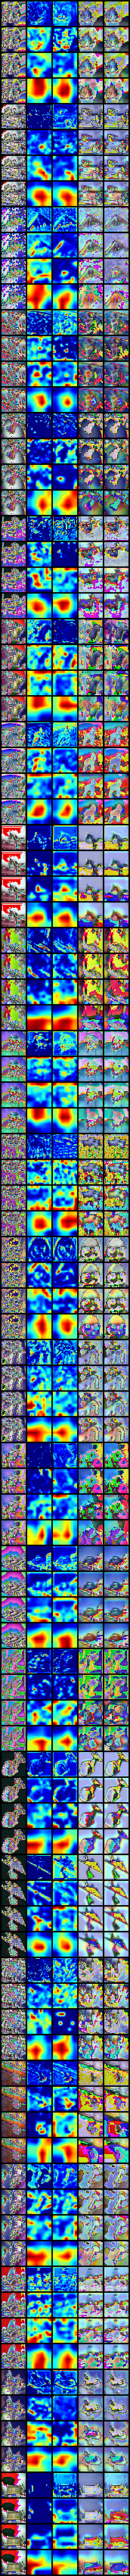

In [21]:
transforms.ToPILImage()(grid_image)
